In [2]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
import string

%reload_ext autoreload
%autoreload 2
from utilsmaster import *

from sklearn.utils import resample
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours, RandomUnderSampler, TomekLinks, CondensedNearestNeighbour
from imblearn.combine import SMOTETomek, SMOTEENN

In [2]:
import pickle

train = pickle.load(open("../pickle/train.pickle", "rb"))
val = pickle.load(open("../pickle/val.pickle", "rb"))

In [3]:
train.head()

,tweet,target,lem
0,big night wcvb martha coakleycharlie baker de...,0,big night wcvb martha coakleycharlie baker deb...
1,not one bitch texting right now followers in...,0,not one bitch texting right now follower inch ...
2,going miss these bitches much far right she...,0,going miss these bitch much far right she rest...
3,hope shes larger than bird,0,hope shes larger than bird
4,all went through much shit together miss th...,0,all went through much shit together miss them ...


In [4]:
train.target.value_counts()

0    17518
1     1069
Name: target, dtype: int64

In [5]:
stop_words = set(stopwords.words('english'))
stop_list = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]
train.lem = train['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))
train.head()

,tweet,target,lem
0,big night wcvb martha coakleycharlie baker de...,0,big night wcvb martha coakleycharlie baker deb...
1,not one bitch texting right now followers in...,0,one bitch texting right follower inch rim inch...
2,going miss these bitches much far right she...,0,going miss bitch much far right resting girl b...
3,hope shes larger than bird,0,hope larger bird
4,all went through much shit together miss th...,0,went much shit together miss bitch


In [6]:
val.lem = val['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))
val.head()

,tweet,target,lem
0,got missed call from bitch,0,got missed call bitch
1,fucking with bad bitch you gone need some mon...,0,fucking bad bitch gone need money lil homie
2,lol credit aint where near good but know th...,0,lol credit aint near good know right man job n...
3,wipe the cum out them faggot contact lens wi...,0,wipe cum faggot contact lens wildin cant see shit
4,niggas cheat they bitch and dont expect pay ...,0,nigga cheat bitch expect pay back whatsoever y...


In [7]:
X_tr = train.lem
X_val = val.lem
y_tr = train.target
y_val = val.target

In [8]:
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

## Multinomial Naive Bayes

Training F1 Score:  0.012999071494893223
Validation F1 Score:  0.0
Training Recall Score:  0.006548175865294668
Validation Recall Score:  0.0
Training Precision Score:  0.875
Validation Precision Score:  0.0
Training Average Precision Score:  0.3116566296066867
Validation Average Precision Score:  0.16459404191710594


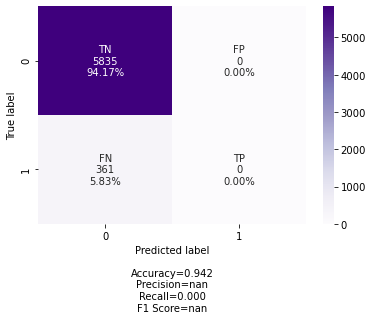

In [12]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)

make_confusion_matrix(cf = confusion_matrix(y_val, y_pr_nb_val))

## Random Forest Classifier

Training Accuracy:  0.9980328861091496
Validation Accuracy:  0.9412951381884204
Training F1 Score:  0.9829022358614642
Validation F1 Score:  0.166189111747851
Training AUC Score:  0.9993512593160092
Validation AUC Score:  0.830553852064754
Training Recall Score:  0.9833333333333333
Validation Recall Score:  0.1
Training Precision Score:  0.9824715162138475
Validation Precision Score:  0.4915254237288136
Training Average Precision Score:  0.986493933791671
Validation Average Precision Score:  0.30667808279232


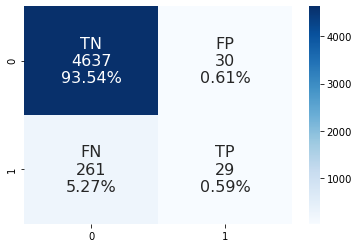

In [16]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_tr = rf.predict(tfidf_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_rf_tr, y_pr_rf_val, rf)

## Logistic Regression

Training Accuracy:  0.9486532835670332
Validation Accuracy:  0.9412951381884204
Training F1 Score:  0.25584795321637427
Validation F1 Score:  0.18487394957983194
Training AUC Score:  0.950024387335673
Validation AUC Score:  0.8704210782973628
Training Recall Score:  0.15350877192982457
Validation Recall Score:  0.11379310344827587
Training Precision Score:  0.7675438596491229
Validation Precision Score:  0.4925373134328358
Training Average Precision Score:  0.5826117025159812
Validation Average Precision Score:  0.3497021490008816


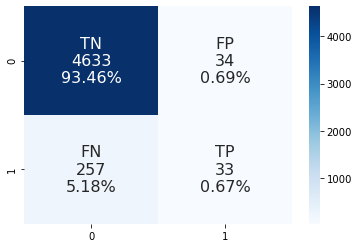

In [20]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_tr = log.predict(tfidf_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_log_tr, y_pr_log_val, log)

# Undersampling Methods

In [22]:
# separate minority and majority classes
majority = train[train.target==0]
minority = train[train.target==1]

#baseline counts
counter = Counter(y_tr)
print("Baseline: ", counter)

Baseline:  Counter({0: 18686, 1: 1140})


## RandomUnderSampler

In [32]:
rus = RandomUnderSampler()
X_tr_rus, y_tr_rus = rus.fit_sample(tfidf_tr, y_tr)
counter_rus = Counter(y_tr_rus)
print("Random Undersampler: ", counter_rus)

Random Undersampler:  Counter({0: 1140, 1: 1140})


Training Accuracy:  0.9403508771929825
Validation Accuracy:  0.7226144845672786
Training F1 Score:  0.9407665505226481
Validation F1 Score:  0.2457487657707076
Training AUC Score:  0.9850423207140659
Validation AUC Score:  0.8314545266471115
Training Recall Score:  0.9473684210526315
Validation Recall Score:  0.7724137931034483
Training Precision Score:  0.9342560553633218
Validation Precision Score:  0.1461187214611872
Training Average Precision Score:  0.9811738014847164
Validation Average Precision Score:  0.3140620656570875


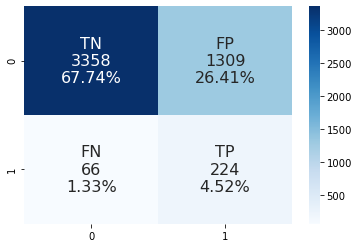

In [34]:
nb2 = MultinomialNB().fit(X_tr_rus, y_tr_rus)
y_pr_nb2_tr = nb2.predict(X_tr_rus)
y_pr_nb2_val = nb2.predict(tfidf_val)
get_metrics(X_tr_rus, y_tr_rus, tfidf_val, y_val, y_pr_nb2_tr, y_pr_nb2_val, nb2)

Training Accuracy:  0.9982456140350877
Validation Accuracy:  0.8355860399435142
Training F1 Score:  0.9982486865148862
Validation F1 Score:  0.3379366368805849
Training AUC Score:  0.9992959372114497
Validation AUC Score:  0.859097256599898
Training Recall Score:  1.0
Validation Recall Score:  0.7172413793103448
Training Precision Score:  0.9965034965034965
Validation Precision Score:  0.22104144527098832
Training Average Precision Score:  0.9988899308000325
Validation Average Precision Score:  0.3115082284232083


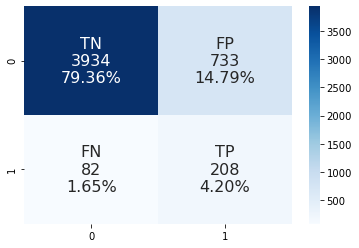

In [35]:
rf2 = RandomForestClassifier(n_estimators=100).fit(X_tr_rus, y_tr_rus)
y_pr_rf2_tr = rf2.predict(X_tr_rus)
y_pr_rf2_val = rf2.predict(tfidf_val)
get_metrics(X_tr_rus, y_tr_rus, tfidf_val, y_val, y_pr_rf2_tr, y_pr_rf2_val, rf2)

Training Accuracy:  0.9083333333333333
Validation Accuracy:  0.8386120637482348
Training F1 Score:  0.9061517736865738
Validation F1 Score:  0.3474714518760196
Training AUC Score:  0.968056325023084
Validation AUC Score:  0.8655818919338274
Training Recall Score:  0.8850877192982456
Validation Recall Score:  0.7344827586206897
Training Precision Score:  0.9282428702851886
Validation Precision Score:  0.22756410256410256
Training Average Precision Score:  0.9620495673976788
Validation Average Precision Score:  0.3227829079863941


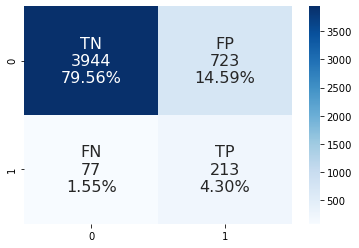

In [36]:
log2 = LogisticRegression().fit(X_tr_rus, y_tr_rus)
y_pr_log2_tr = log2.predict(X_tr_rus)
y_pr_log2_val = log2.predict(tfidf_val)
get_metrics(X_tr_rus, y_tr_rus, tfidf_val, y_val, y_pr_log2_tr, y_pr_log2_val, log2)

## Condensed Nearest Neighbour

In [ ]:
cnn = CondensedNearestNeighbour(n_neighbors=2)
X_tr_cnn, y_tr_cnn = cnn.fit_resample(tfidf_tr, y_tr)
counter_cnn = Counter(y_tr_cnn)
print("Condensed Nearest Neighbors: ", counter_cnn)

Training Accuracy:  0.7017010935601458
Validation Accuracy:  0.058704861811579585
Training F1 Score:  0.822807650667629
Validation F1 Score:  0.1105604269919939
Training AUC Score:  0.9351293252895083
Validation AUC Score:  0.7233418056345728
Training Recall Score:  1.0
Validation Recall Score:  1.0
Training Precision Score:  0.6989576946658492
Validation Precision Score:  0.05851493139628733
Training Average Precision Score:  0.9642809276579059
Validation Average Precision Score:  0.18059492210399705


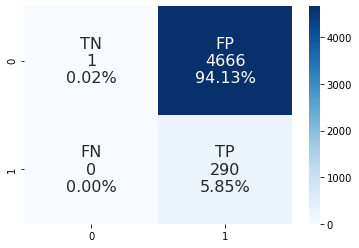

In [56]:
nb3 = MultinomialNB().fit(X_tr_cnn, y_tr_cnn)
y_pr_nb3_tr = nb3.predict(X_tr_cnn)
y_pr_nb3_val = nb3.predict(tfidf_val)
get_metrics(X_tr_cnn, y_tr_cnn, tfidf_val, y_val, y_pr_nb3_tr, y_pr_nb3_val, nb3)

Training Accuracy:  0.982989064398542
Validation Accuracy:  0.3855154327214041
Training F1 Score:  0.9878366637706342
Validation F1 Score:  0.1434195725534308
Training AUC Score:  0.9984744469870328
Validation AUC Score:  0.7483600925057077
Training Recall Score:  0.9973684210526316
Validation Recall Score:  0.8793103448275862
Training Precision Score:  0.9784853700516352
Validation Precision Score:  0.07807715860379669
Training Average Precision Score:  0.9992058754289057
Validation Average Precision Score:  0.20259220968955083


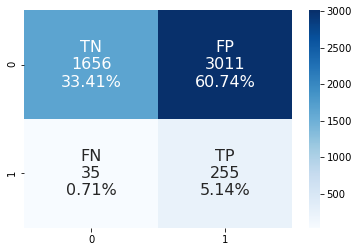

In [57]:
rf3 = RandomForestClassifier(n_estimators=100).fit(X_tr_cnn, y_tr_cnn)
y_pr_rf3_tr = rf3.predict(X_tr_cnn)
y_pr_rf3_val = rf3.predict(tfidf_val)
get_metrics(X_tr_cnn, y_tr_cnn, tfidf_val, y_val, y_pr_rf3_tr, y_pr_rf3_val, rf3)

Training Accuracy:  0.778857837181045
Validation Accuracy:  0.19568287270526527
Training F1 Score:  0.8609625668449198
Validation F1 Score:  0.12469813391877056
Training AUC Score:  0.9175767977255391
Validation AUC Score:  0.7752595257974184
Training Recall Score:  0.9885964912280701
Validation Recall Score:  0.9793103448275862
Training Precision Score:  0.7625169147496617
Validation Precision Score:  0.06658851113716295
Training Average Precision Score:  0.9512331201651028
Validation Average Precision Score:  0.2224723140206576


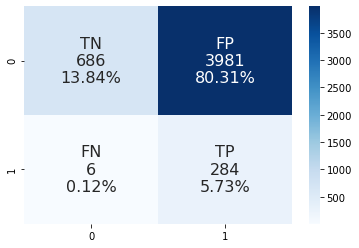

In [58]:
log3 = LogisticRegression().fit(X_tr_cnn, y_tr_cnn)
y_pr_log3_tr = log3.predict(X_tr_cnn)
y_pr_log3_val = log3.predict(tfidf_val)
get_metrics(X_tr_cnn, y_tr_cnn, tfidf_val, y_val, y_pr_log3_tr, y_pr_log3_val, log3)

## SMOTE-ENN

In [65]:
sme = SMOTEENN(sampling_strategy="minority")
X_tr_sme, y_tr_sme = sme.fit_sample(tfidf_tr, y_tr)
counter_sme = Counter(y_tr_sme)
print("SMOTE-ENN: ", counter_sme)

SMOTE-ENN:  Counter({1: 18593, 0: 17159})


Training Accuracy:  0.9536529424927277
Validation Accuracy:  0.8123865241073229
Training F1 Score:  0.9569308346112858
Validation F1 Score:  0.2879019908116386
Training AUC Score:  0.9944190504603934
Validation AUC Score:  0.8057557465107172
Training Recall Score:  0.9900500188242887
Validation Recall Score:  0.6482758620689655
Training Precision Score:  0.9259557344064386
Validation Precision Score:  0.18503937007874016
Training Average Precision Score:  0.9947086398951036
Validation Average Precision Score:  0.279597413805108


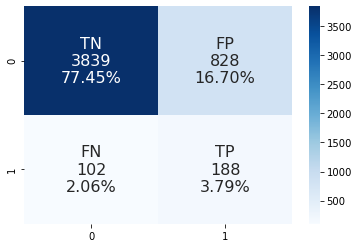

In [66]:
nb4 = MultinomialNB().fit(X_tr_sme, y_tr_sme)
y_pr_nb4_tr = nb4.predict(X_tr_sme)
y_pr_nb4_val = nb4.predict(tfidf_val)
get_metrics(X_tr_sme, y_tr_sme, tfidf_val, y_val, y_pr_nb4_tr, y_pr_nb4_val, nb4)

Training Accuracy:  1.0
Validation Accuracy:  0.9283841032882792
Training F1 Score:  1.0
Validation F1 Score:  0.39316239316239315
Training AUC Score:  1.0
Validation AUC Score:  0.8432685842636857
Training Recall Score:  1.0
Validation Recall Score:  0.39655172413793105
Training Precision Score:  1.0
Validation Precision Score:  0.3898305084745763
Training Average Precision Score:  1.0
Validation Average Precision Score:  0.295144991097696


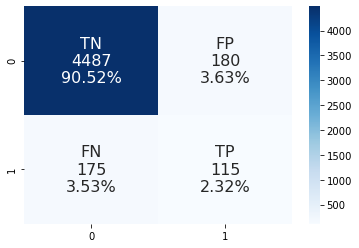

In [68]:
rf4 = RandomForestClassifier(n_estimators=100).fit(X_tr_sme, y_tr_sme)
y_pr_rf4_tr = rf4.predict(X_tr_sme)
y_pr_rf4_val = rf4.predict(tfidf_val)
get_metrics(X_tr_sme, y_tr_sme, tfidf_val, y_val, y_pr_rf4_tr, y_pr_rf4_val, rf4)

Training Accuracy:  0.9536529424927277
Validation Accuracy:  0.8123865241073229
Training F1 Score:  0.9569308346112858
Validation F1 Score:  0.2879019908116386
Training AUC Score:  0.9934403999617762
Validation AUC Score:  0.8665206179854148
Training Recall Score:  0.9900500188242887
Validation Recall Score:  0.6482758620689655
Training Precision Score:  0.9259557344064386
Validation Precision Score:  0.18503937007874016
Training Average Precision Score:  0.9926542696920625
Validation Average Precision Score:  0.30824173099431246


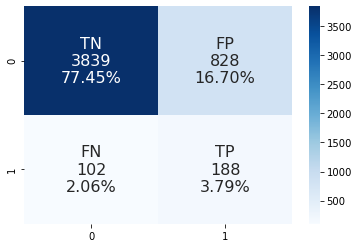

In [69]:
log4 = LogisticRegression().fit(X_tr_sme, y_tr_sme)
y_pr_log4_tr = nb4.predict(X_tr_sme)
y_pr_log4_val = nb4.predict(tfidf_val)
get_metrics(X_tr_sme, y_tr_sme, tfidf_val, y_val, y_pr_log4_tr, y_pr_log4_val, log4)